In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram


from bbl import *
from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [3]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = 5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.
delta_t = 60.

In [63]:
bbl = bbl_exp(k0, k1, h, N, f, θ)
bbl_f0 = bbl_exp(k0, k1, h, N, 0., θ)

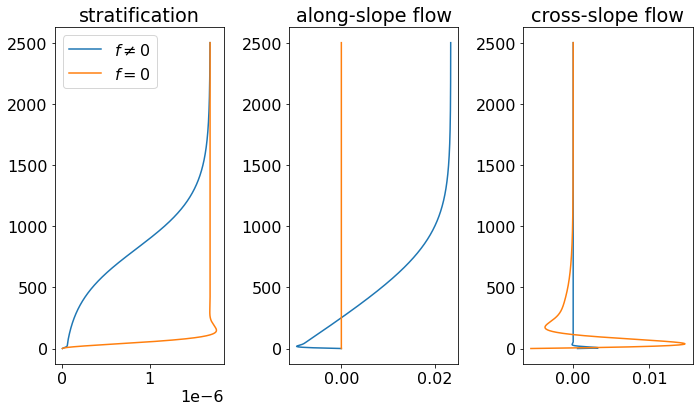

In [64]:
fig, axes = plt.subplots(1,3)
for m, name in zip([bbl, bbl_f0], [r'$f\neq 0$', r'$f=0$']):
    axes[0].plot(m["bz"], m["z"], label=name)
    axes[1].plot(m["v"], m["z"])
    axes[2].plot(m["u"], m["z"])
axes[0].legend()
axes[0].set_title("stratification")
axes[1].set_title("along-slope flow")
axes[2].set_title("cross-slope flow")
plt.tight_layout()

In [65]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
ds = ds.isel(time=[-1])
ds, grid = add_rotated_coords(ds, θ)
ds = add_thalweg(ds)
ds = add_background_temp(ds, Γ)

dx = 600.; dy = 600.;
Ly = ds.YC.size*dy
Lx = ds.XC.size*dx

In [66]:
snap = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
snap = snap.isel(time=[-1])
snap, _ = add_rotated_coords(snap, θ)
snap = add_background_temp(snap, Γ)

In [67]:
mx_mean_depth = (-ds['Depth'] + ds.attrs['H']).mean(dim='XC')
mx_min_depth = (-ds['Depth'] + ds.attrs['H']).min(dim='XC')

In [68]:
def format_yz_section(ax):
    ax.set_xlabel("cross-canyon distance [km]")
    ax.set_xticks(np.arange(0., 80e3, 10e3))
    ax.set_xticklabels(np.arange(0, 80, 10))
    ax.set_xlim([60e3, 0e3])
    ax.set_ylabel("height above mean-slope [m]")
    
def format_xz_section(ax):
    ax.set_xlabel("along-canyon distance [km]")
    ax.set_xticks(np.arange(0., 500e3, 50e3))
    ax.set_xticklabels(np.arange(0, 500, 50))
    ax.set_xlim([0, 480e3])
    ax.set_ylabel("depth [m]")

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


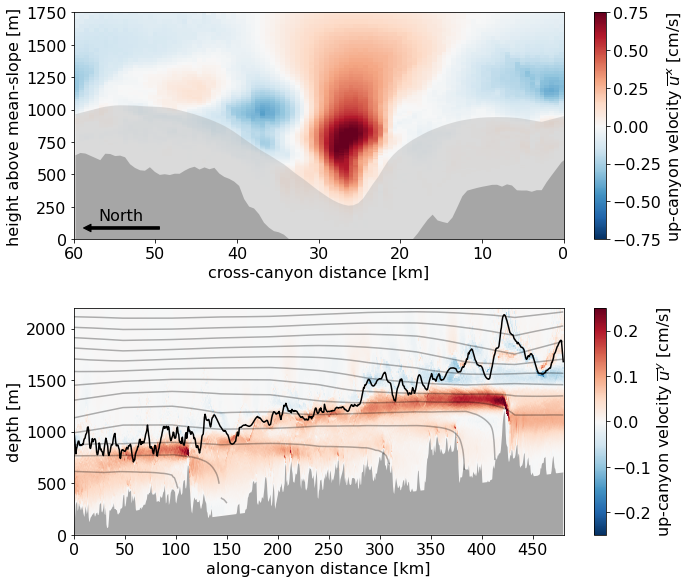

In [69]:
fig, axes = plt.subplots(2,1, figsize=(10,8.5))

ax=axes[0]
q = (ds['UVEL']*100).mean(dim='XG', skipna=True).plot(ax=ax)
q.set_clim([-0.75, 0.75])
q.colorbar.set_label(r"up-canyon velocity $\overline{u}^{x}$ [cm/s]")
ax.fill_between((ds['YC']-dx*1.1)*1.0125, 0.*mx_mean_depth, mx_mean_depth, facecolor=nancol, alpha=0.35)
ax.fill_between((ds['YC']-dx*1.1)*1.0125, 0.*mx_min_depth, mx_min_depth, facecolor=nancol)
format_yz_section(ax)
ax.set_title("")
ax.set_ylim([0, 1750])

arrowprops = dict(headlength=7.5, width=2.5, headwidth=7.5, color='k')
ax.annotate(r"North", (0.05, 0.085), xycoords="axes fraction");
ax.annotate("", (0.02, 0.05), (0.175, 0.05), xycoords="axes fraction", arrowprops=arrowprops);

ax=axes[1]
q = (ds['UVEL']*100).mean(dim='YC', skipna=True).plot(ax=ax, x='Xr_U', y='Zr_U')
q.set_clim([-0.25, 0.25])
q.colorbar.set_label(r"up-canyon velocity $\overline{u}^{y}$ [cm/s]")
#ds['THETA_BG'].mean(dim=['YC', 'time'], skipna=True).plot.contour(x='Xr', y='Zr', colors='k', alpha=0.3, levels=np.arange(0.5, 3., 0.1))
ds['THETA_BG'].where(ds['hFacC']!=0.).mean(dim=['YC', 'time'], skipna=True).isel(XC=np.append(np.arange(0,800,80), [799])).plot.contour(x='Xr', y='Zr', colors='k', alpha=0.3, levels=np.arange(0.5, 3., 0.1))
crest_dep = irregular_section(-ds['Depthr'] + ds.attrs['H'], ds['j_thalweg'].values, width=25, invert_mask=True)
crest_dep.mean(dim='YC', skipna=True).plot(ax=ax, color="k")
thalweg_dep = irregular_section(-ds['Depthr'] + ds.attrs['H'], ds['j_thalweg'].values)
ax.fill_between(ds['XC'], thalweg_dep*0., thalweg_dep, facecolor=nancol)
format_xz_section(ax)
ax.set_title("")
ax.set_ylim([0, 2200])

plt.tight_layout()
plt.savefig("../../figures/BBTRE/meanflow.png", dpi=100., bbox_inches='tight')

In [70]:
geo = xr.open_dataset(data_dir+"geocoords.nc").drop(["X", "Y"])
moorings = {
    "CTS17-P1": {'coords': (-14.58, -21.12)},
    "CTS17-P2": {'coords': (-14.59, -21.10)},
    "T05": {'coords': (-17.-48.5/60., -21.-36.9/60.)}
}

In [71]:
lons = [mooring['coords'][0] for mooring in moorings.values()]
lats = [mooring['coords'][1] for mooring in moorings.values()]
samples = sample_locations(geo, lons, lats)

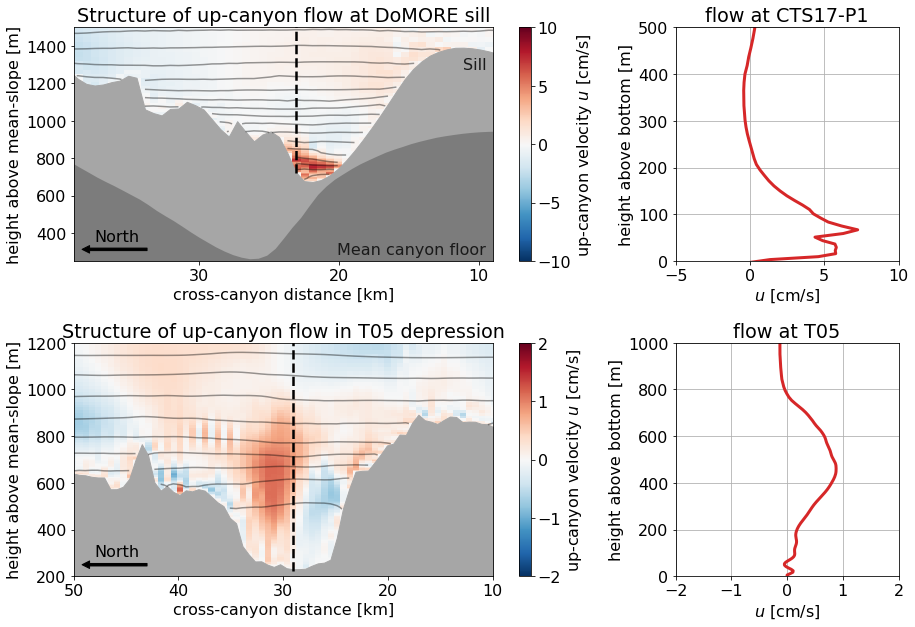

In [72]:
n = 0
i = samples['i'][n]
j = samples['j'][n]-1

fig = plt.figure(figsize=(13,9))
gs = fig.add_gridspec(2, 3)

ax = fig.add_subplot(gs[:1, :2])
q = (ds['UVEL']*100).isel(XG=i).plot(ax=ax)
q.set_clim([-10, 10])
q.colorbar.set_label(r"up-canyon velocity $u$ [cm/s]")
snap['THETA_BG'].isel(XC=[i, i-1]).mean(['XC', 'time'], skipna=False).plot.contour(ax=ax, colors='k', levels=np.arange(0., 3.0, 0.05), alpha=0.4)
format_yz_section(ax)
ax.set_title("Structure of up-canyon flow at DoMORE sill")
ax.set_ylim([250, 1500])

sec_depth = (-ds['Depth']+ds.attrs['H']).isel(XC=[i, i-1]).max('XC')
ax.fill_between(ds['YC'], 0.*sec_depth, sec_depth, color=nancol)
YC_sample = ds['YC'][j]
ax.plot([YC_sample, YC_sample], [720., 1800.], "k--", lw=2.5)
ax.set_xlim(39e3, 9e3)
ax.fill_between((ds['YC']-dx*1.1)*1.0125, 0.*mx_mean_depth, mx_mean_depth, facecolor='k', alpha=0.25)
ax.annotate("Sill", (0.93, 0.82), color=(0.1, 0.1, 0.1), xycoords='axes fraction')
ax.annotate("Mean canyon floor", (0.628, 0.03), color=(0.1, 0.1, 0.1), xycoords='axes fraction')

arrowprops = dict(headlength=7.5, width=2.5, headwidth=7.5, color='k')
ax.annotate(r"North", (0.05, 0.085), xycoords="axes fraction");
ax.annotate("", (0.02, 0.05), (0.175, 0.05), xycoords="axes fraction", arrowprops=arrowprops);

ax = fig.add_subplot(gs[:1, 2:])
ds = ds.assign_coords({"Zhab": ds['Z']-720.})
(ds['UVEL']*100).isel(time=0, XG=i, YC=j).plot(y='Zhab', color="C3", lw=3)
plt.ylim([0., 500.])
plt.xlim([-5, 10])
plt.title("flow at CTS17-P1")
plt.ylabel("height above bottom [m]")
plt.xlabel(r"$u$ [cm/s]")
plt.grid(True)

n = 2
i = samples['i'][n]
j = samples['j'][n]

ax = fig.add_subplot(gs[1:, :2])
q = (ds['UVEL']*100).isel(XG=i).plot(ax=ax)
q.set_clim([-2, 2])
q.colorbar.set_label(r"up-canyon velocity $u$ [cm/s]")
snap['THETA_BG'].isel(XC=[i, i-1]).mean(['XC', 'time'], skipna=False).plot.contour(ax=ax, colors='k', levels=np.arange(0., 3.0, 0.05), alpha=0.4)
format_yz_section(ax)
ax.set_title("Structure of up-canyon flow in T05 depression")
ax.set_ylim([200, 1200])

sec_depth = (-ds['Depth']+ds.attrs['H']).isel(XC=[i, i-1]).max('XC')
ax.fill_between(ds['YC'], 0.*sec_depth, sec_depth, color=nancol)
YC_sample = ds['YC'][j]
ax.plot([YC_sample, YC_sample], [225., 1800.], "k--", lw=2.5)
ax.set_xlim(50e3, 10e3)

arrowprops = dict(headlength=7.5, width=2.5, headwidth=7.5, color='k')
ax.annotate(r"North", (0.05, 0.085), xycoords="axes fraction");
ax.annotate("", (0.02, 0.05), (0.175, 0.05), xycoords="axes fraction", arrowprops=arrowprops);

ax = fig.add_subplot(gs[1:, 2:])
ds = ds.assign_coords({"Zhab": ds['Z']-225.})
(ds['UVEL']*100).isel(time=0, XG=i, YC=j).plot(y='Zhab', color="C3", lw=3)
plt.ylim([0., 1000.])
plt.xlim([-2, 2])
plt.title("flow at T05")
plt.ylabel("height above bottom [m]")
plt.xlabel(r"$u$ [cm/s]")
plt.grid(True)

plt.tight_layout()
plt.savefig("../../figures/BBTRE/simulated_moorings.png", dpi=100., bbox_inches='tight')